In [49]:
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import copy
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import MACCSkeys, GraphDescriptors
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.maxMols = 100

In [50]:
scaffold_smiles = {
    'benzene': '[*:1]c1ccccc1[*:2]',
    'pyridine': '[*:1]c1ccncc1[*:2]',
    'cyclohexane': '[*:1]C1CCCCC1[*:2]'
}

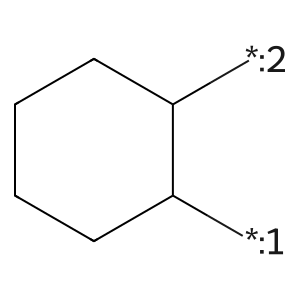

In [51]:
benzene_mol = Chem.MolFromSmiles(scaffold_smiles['cyclohexane'])
Draw.MolToImage(benzene_mol)

In [72]:
substituents = [
  "[*]C", "[*]CC", "[*]CCC", "[*]CO", "[*]OC", "[*]CN", "[*]NC",
    "[*]C(=O)O", "[*]C(=O)N", "[*]N=C=O", "[*][N+](=O)[O-]",
    "[*]F", "[*]Cl", "[*]Br", "[*]I", "[*]SC", "[*]CCO", "[*]C#N",
    "[*]OCC", "[*]CCl", "[*]C(F)(F)F", "[*]C=CC"
]

substituent_mols = [Chem.MolFromSmiles(s) for s in substituents]

In [92]:
import os
from itertools import product

def attach_two_subs(scaffold_smi, sub1_smi, sub2_smi):
    """Attach two substituents to a scaffold with [*] attachment points"""
    scaffold = Chem.MolFromSmiles(scaffold_smi)
    sub1 = Chem.MolFromSmiles(sub1_smi)
    sub2 = Chem.MolFromSmiles(sub2_smi)

    try:
        #Combine scaffold and substituents 
        combo = Chem.ReplaceSubstructs(scaffold, Chem.MolFromSmiles('[*]'), sub1, True)[0]
        combo = Chem.ReplaceSubstructs(combo, Chem.MolFromSmiles('[*]'), sub2, True)[0]
        Chem.SanitizeMol(combo)
        return combo
    except:
        return None

library = []
for scaffold_name, scaffold_smi in scaffold_smiles.items():
    for sub1, sub2 in product(substituents, repeat = 2):
        mol = attach_two_subs(scaffold_smi, sub1, sub2)
        if mol: 
            library.append({
            "Scaffold": scaffold_name,
            "Sub1": sub1,
            "Sub2": sub2,
            "SMILES": Chem.MolToSmiles(mol)
        })

df_library = pd.DataFrame(library)

os.makedirs("data", exist_ok=True)

df_library.to_csv("data/molecules.csv", index=False)
print(f"Libreria salvata con successo in data/molecules.csv - {len(df_library)} molecole generate.")

Libreria salvata con successo in data/molecules.csv - 1452 molecole generate.


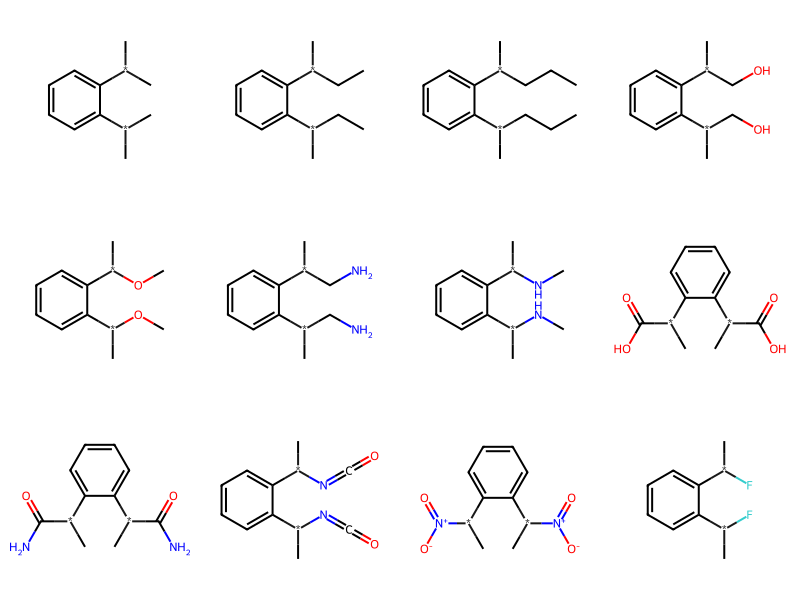

In [93]:
mols = [Chem.MolFromSmiles(smi) for smi in df_library['SMILES'].tolist()[:12]]
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200))
img

In [94]:
descriptor_list = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 
                   'TPSA', 'NumRotatableBonds', 'HeavyAtomCount', 'RingCount']

calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_list)

df_library['Mol'] = df_library['SMILES'].apply(Chem.MolFromSmiles)
desc_data = [calc.CalcDescriptors(m) for m in df_library['Mol']]
desc_df = pd.DataFrame(desc_data, columns=descriptor_list)
df_features = pd.concat([df_library, desc_df], axis=1)

In [95]:
df_features['Lipinski_Violations'] = (
    (df_features['MolWt'] > 500).astype(int) +
    (df_features['MolLogP'] > 5).astype(int) +
    (df_features['NumHDonors'] > 5).astype(int) +
    (df_features['NumHAcceptors'] > 10).astype(int)
)

In [96]:
df_features.to_csv('data/molecules_descriptors.csv', index=False)

In [97]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [98]:
import seaborn as sns

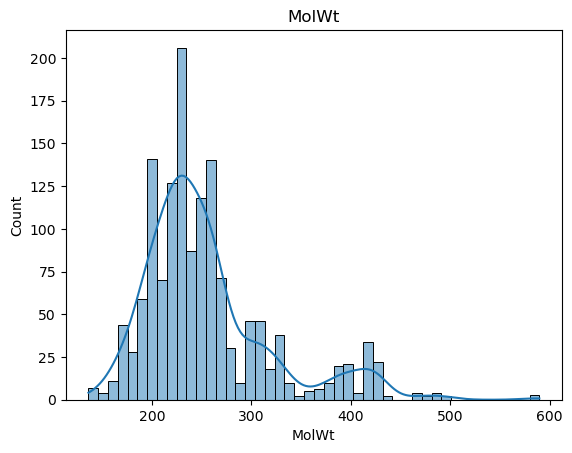

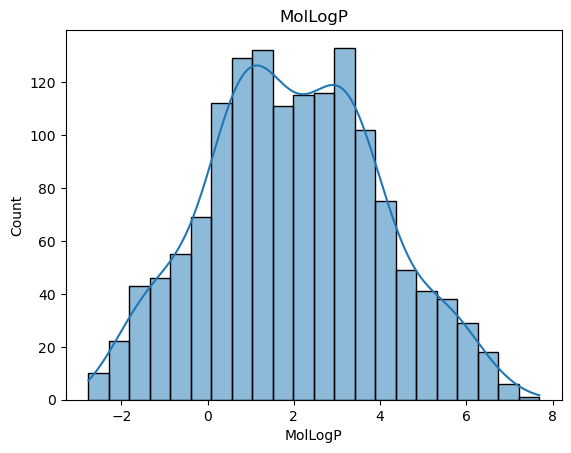

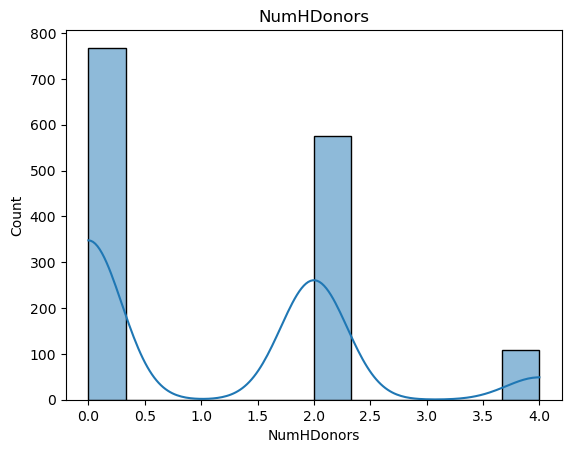

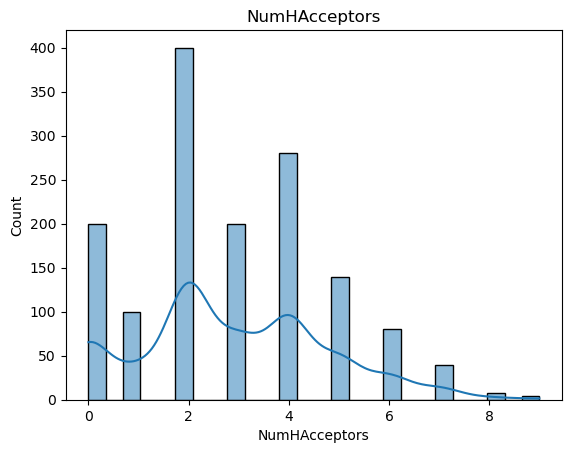

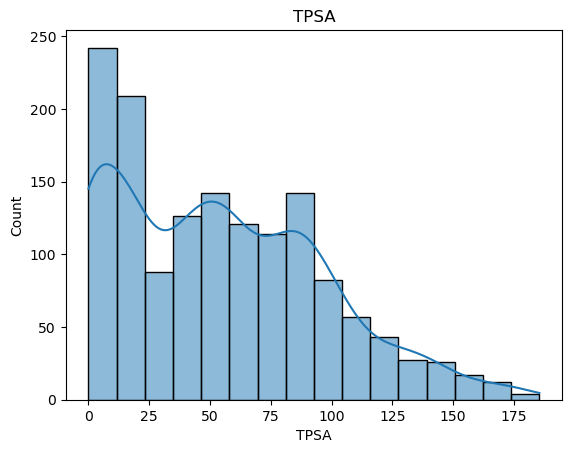

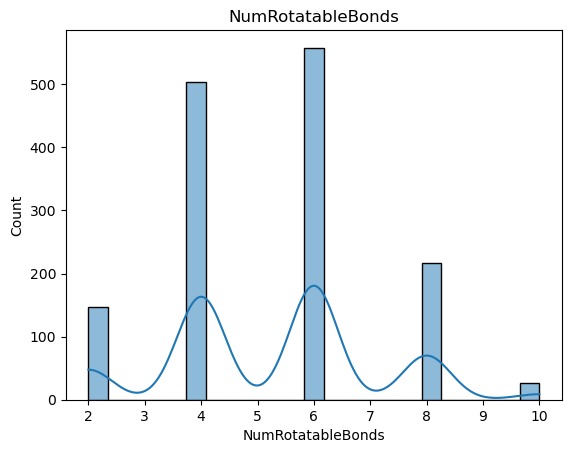

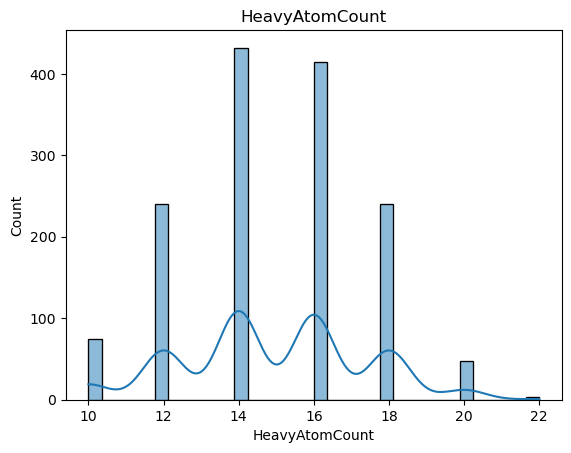

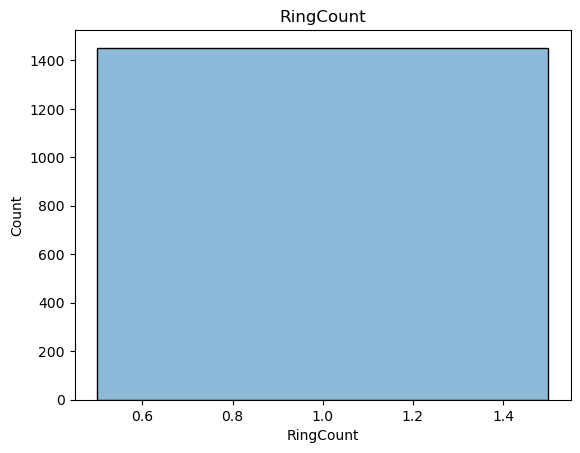

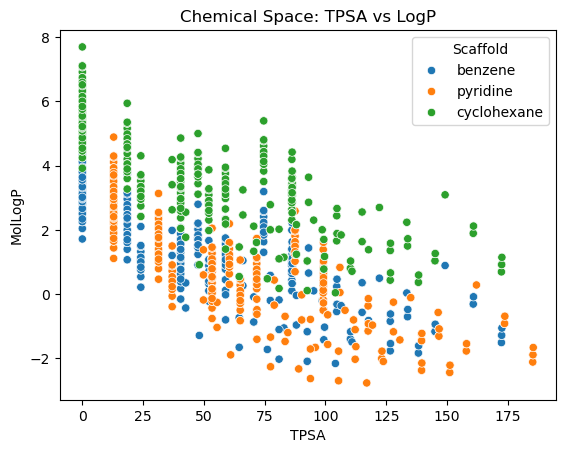

In [99]:
for col in descriptor_list:
    sns.histplot(df_features[col], kde=True)
    plt.title(col)
    plt.show()

sns.scatterplot(x='TPSA', y='MolLogP', data=df_features, hue='Scaffold')
plt.title('Chemical Space: TPSA vs LogP')
plt.show()

In [100]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [105]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

features = [f for f in descriptor_list if f != 'MolLogP']

X = df_features[features]
y = df_features['MolLogP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R2: 0.8744312502430313
MAE: 0.4991433666298487


In [106]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("CV R2 mean:", scores.mean(), "std:", scores.std())

CV R2 mean: 0.4184199897127825 std: 0.37045143804301667


In [102]:
print("Numero totale di molecole:", len(df_features))
print("Train set:", len(X_train))
print("Test set:", len(X_test))

Numero totale di molecole: 1452
Train set: 1161
Test set: 291


             feature  importance
3               TPSA    0.352869
2      NumHAcceptors    0.294471
0              MolWt    0.230900
1         NumHDonors    0.057160
5     HeavyAtomCount    0.033961
4  NumRotatableBonds    0.030639
6          RingCount    0.000000


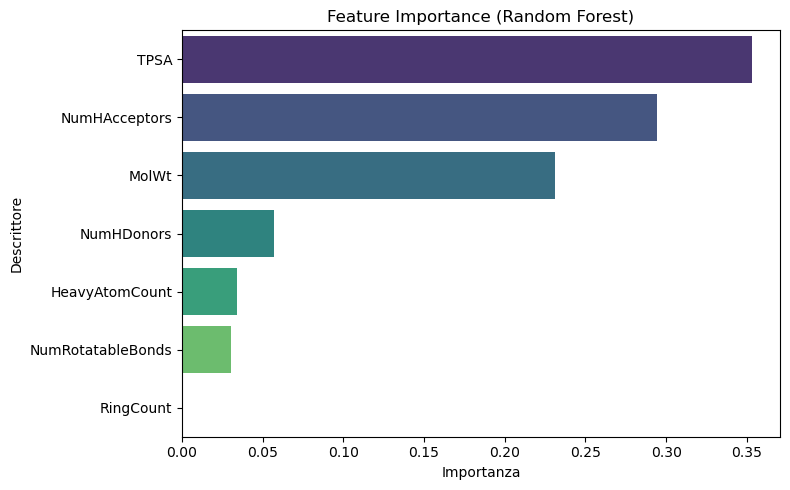

In [112]:
importances = model.feature_importances_
imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print(imp_df.head(10))

plt.figure(figsize=(8, 5))
sns.barplot(
    x='importance',
    y='feature',
    data=imp_df,
    hue='feature',           
    dodge=False,             
    legend=False,           
    palette='viridis'
)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importanza')
plt.ylabel('Descrittore')
plt.tight_layout()
plt.show()

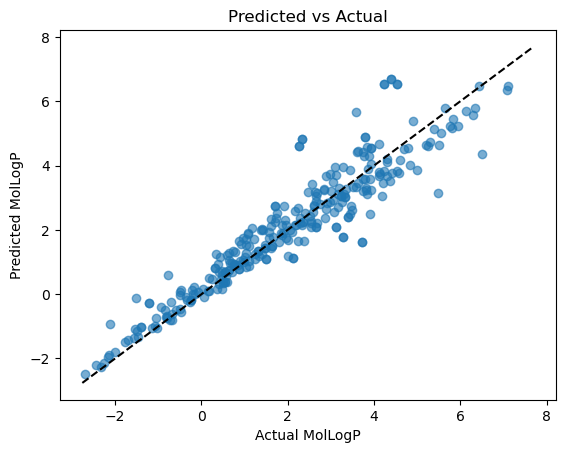

In [113]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("Actual MolLogP")
plt.ylabel("Predicted MolLogP")
plt.title("Predicted vs Actual")
plt.show()

In [119]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


Tanimoto(0,1): 0.5263157894736842
Tanimoto(0,2): 0.47619047619047616


100%|█████████████████████████████████████| 1452/1452 [00:07<00:00, 202.99it/s]


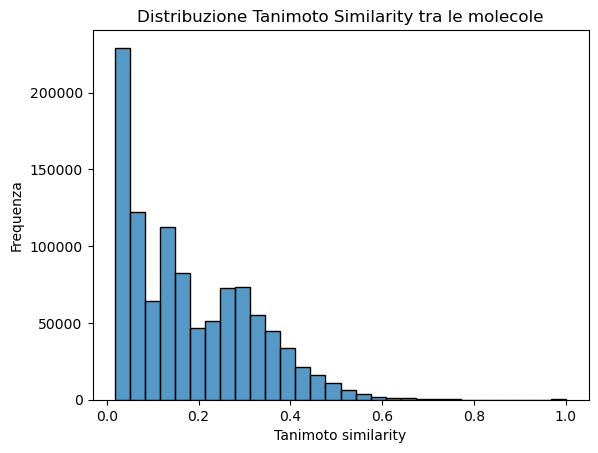

In [120]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  

gen = GetMorganGenerator(radius=2, fpSize=1024)
fps = [gen.GetFingerprint(mol) for mol in df_features['Mol'] if mol is not None]

similarity_01 = DataStructs.TanimotoSimilarity(fps[0], fps[1])
similarity_02 = DataStructs.TanimotoSimilarity(fps[0], fps[2])

print("Tanimoto(0,1):", similarity_01)
print("Tanimoto(0,2):", similarity_02)

n = len(fps)
similarity_matrix = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(i + 1, n):
        sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim  # simmetrica

sns.histplot(similarity_matrix[np.triu_indices(n, k=1)], bins=30)
plt.title('Distribuzione Tanimoto Similarity tra le molecole')
plt.xlabel('Tanimoto similarity')
plt.ylabel('Frequenza')
plt.show()

In [121]:
print("✅ Progetto completato con successo!")
print(f"Totale molecole generate: {len(df_features)}")
print(f"R2 test: {r2_score(y_test, y_pred):.3f}")
print(f"MAE test: {mean_absolute_error(y_test, y_pred):.3f}")
print("Libreria molecolare, modello e analisi di similarità completati.")

✅ Progetto completato con successo!
Totale molecole generate: 1452
R2 test: 0.874
MAE test: 0.499
Libreria molecolare, modello e analisi di similarità completati.
